In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.random.utils import params_broadcast_shapes
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import pearsonr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples


In [3]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [4]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()

In [5]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'])
date_data= df['start_of_week']
channel_data = df[spend_channels]
control_data=None
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)

In [6]:
df['day'] = pd.to_datetime(df.start_of_week).dt.dayofyear
n_order = 3
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
# trend feature

df['t'] = (df.index - df.index.min()) / (df.index.max() - df.index.min())

control_data = pd.concat([df['t'], fourier_features], axis=1)
control_data.head()


,t,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3
0,0.000000,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667
1,0.009709,0.363482,-0.931601,-0.677240,0.735762,0.898354,-0.439273
2,0.019417,-0.957852,-0.287261,0.550307,-0.834962,0.641689,0.766965
3,0.029126,-0.985424,-0.170118,0.335276,-0.942120,0.871351,0.490660
4,0.038835,-0.998724,-0.050511,0.100892,-0.994897,0.988531,0.151016


In [7]:
target_scaler = MaxAbsScaler()
target_scaler.fit(target_data.values.reshape(-1,1))
target_scaled = pd.Series(target_scaler.transform(target_data.values.reshape(-1,1)).flatten())

channel_scaler = MaxAbsScaler()
channel_scaler.fit(channel_data)
channel_scaled = pd.DataFrame(channel_scaler.transform(channel_data),columns=channel_data.columns)

<Axes: >

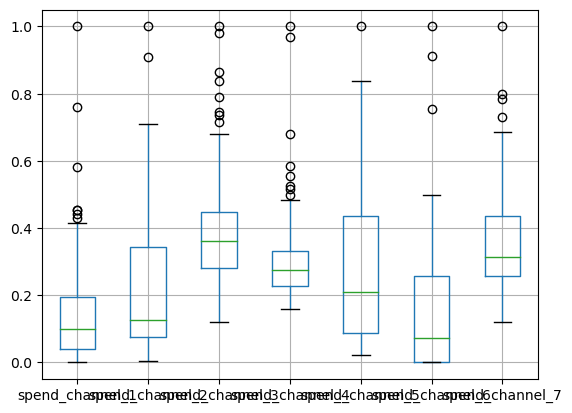

In [8]:
channel_scaled.boxplot()

In [9]:
coords={"date": date_data,
        "channel": channel_scaled,
        "control":control_data}

In [63]:
max_lag=13

with pm.Model(coords=coords) as model:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    control_data_ = pm.MutableData(
        name="control_data", value=control_data, dims=("date", "control")
    )
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=5, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="control"
    )
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=15, beta=1)
    
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var = intercept + channel_contributions.sum(axis=-1)

    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=control_data_ * fourier_control,
        dims=("date", "control"),
    )
    
    mu_var += control_contributions.sum(axis=-1)

    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.StudentT(
        name="likelihood",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=target_,
        dims="date",
    )
    model_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


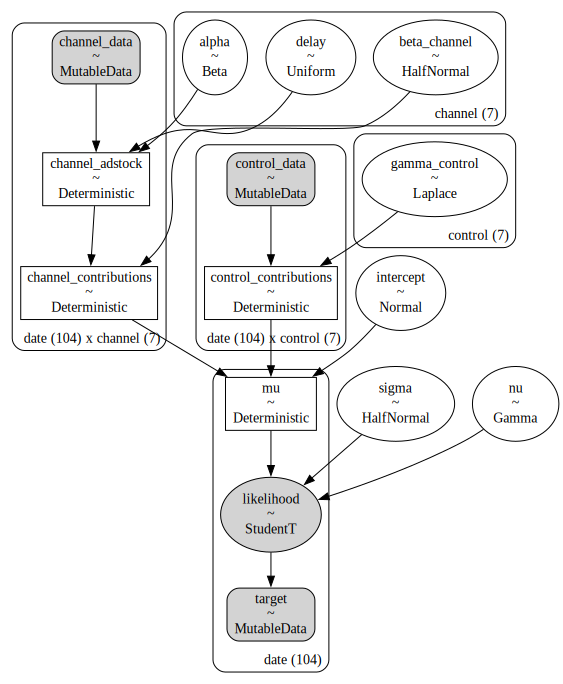

In [64]:
pm.model_to_graphviz(model=model)

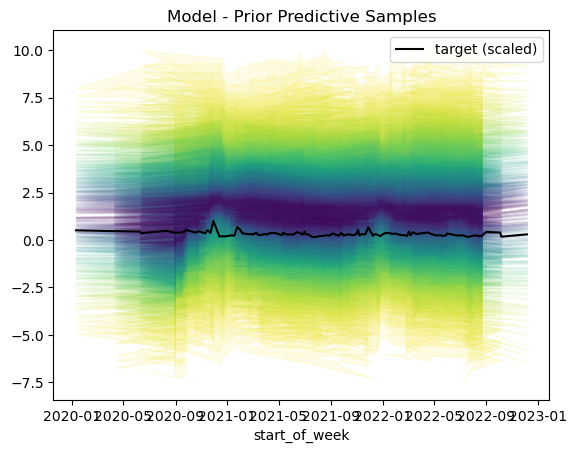

In [65]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


Prior predictive:
- negative sales might be restricted since it is suggesting negative sales

In [66]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:07.129387
Sampling...


Compiling.. :   0%|                                                                                        | 0/9000 [00:00<?, ?it/s]

  0%|                                                                                                      | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                        | 0/9000 [00:00<?, ?it/s]


  0%|                                                                                                      | 0/9000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                                        | 0/9000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                                     | 0/9000 [00:06<?, ?it/s]


Running chain 3:   0%|                                                                                     | 0/9000 [00:06<?, ?it/s]

Running chain 2:   5%|███▋                                 

Running chain 0:  75%|██████████████████████████████████████████████████████▊                  | 6750/9000 [00:42<00:11, 191.35it/s]

Running chain 1: 100%|█████████████████████████████████████████████████████████████████████████| 9000/9000 [00:42<00:00, 278.21it/s]


Running chain 3:  75%|██████████████████████████████████████████████████████▊                  | 6750/9000 [00:42<00:11, 197.54it/s]

Running chain 0:  80%|██████████████████████████████████████████████████████████▍              | 7200/9000 [00:44<00:09, 195.54it/s]


Running chain 3:  80%|██████████████████████████████████████████████████████████▍              | 7200/9000 [00:45<00:08, 201.68it/s]

Running chain 0:  85%|██████████████████████████████████████████████████████████████           | 7650/9000 [00:46<00:06, 195.98it/s]


Running chain 0:  90%|█████████████████████████████████████████████████████████████████▋       | 8100/9000 [00:48<00:04, 201.95it/s]


Running chain 0:  95%|████████████████████████████████████

Sampling time =  0:00:54.210693
Transforming variables...
Transformation time =  0:00:01.784849
Computing Log Likelihood...
Log Likelihood time =  0:00:02.105336


Sampling: [likelihood]


In [67]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','intercept','beta_channel','nu','gamma_control'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[spend_channel_1],0.374,0.162,0.081,0.666,0.001,0.001,31014.0,20859.0,1.0
alpha[spend_channel_2],0.391,0.164,0.087,0.685,0.001,0.001,32437.0,18924.0,1.0
alpha[spend_channel_3],0.359,0.159,0.072,0.647,0.001,0.001,27735.0,18850.0,1.0
alpha[spend_channel_4],0.375,0.161,0.088,0.672,0.001,0.001,29674.0,19661.0,1.0
alpha[spend_channel_5],0.374,0.161,0.086,0.671,0.001,0.001,30599.0,19954.0,1.0
alpha[spend_channel_6],0.371,0.163,0.080,0.663,0.001,0.001,33000.0,21497.0,1.0
alpha[spend_channel_7],0.319,0.152,0.054,0.596,0.001,0.001,21683.0,20546.0,1.0
delay[spend_channel_1],5.718,2.161,0.365,9.189,0.019,0.014,12980.0,7695.0,1.0
delay[spend_channel_2],4.091,3.167,0.000,10.077,0.035,0.025,7809.0,13263.0,1.0
delay[spend_channel_3],3.358,3.739,0.000,10.654,0.047,0.033,6358.0,17645.0,1.0


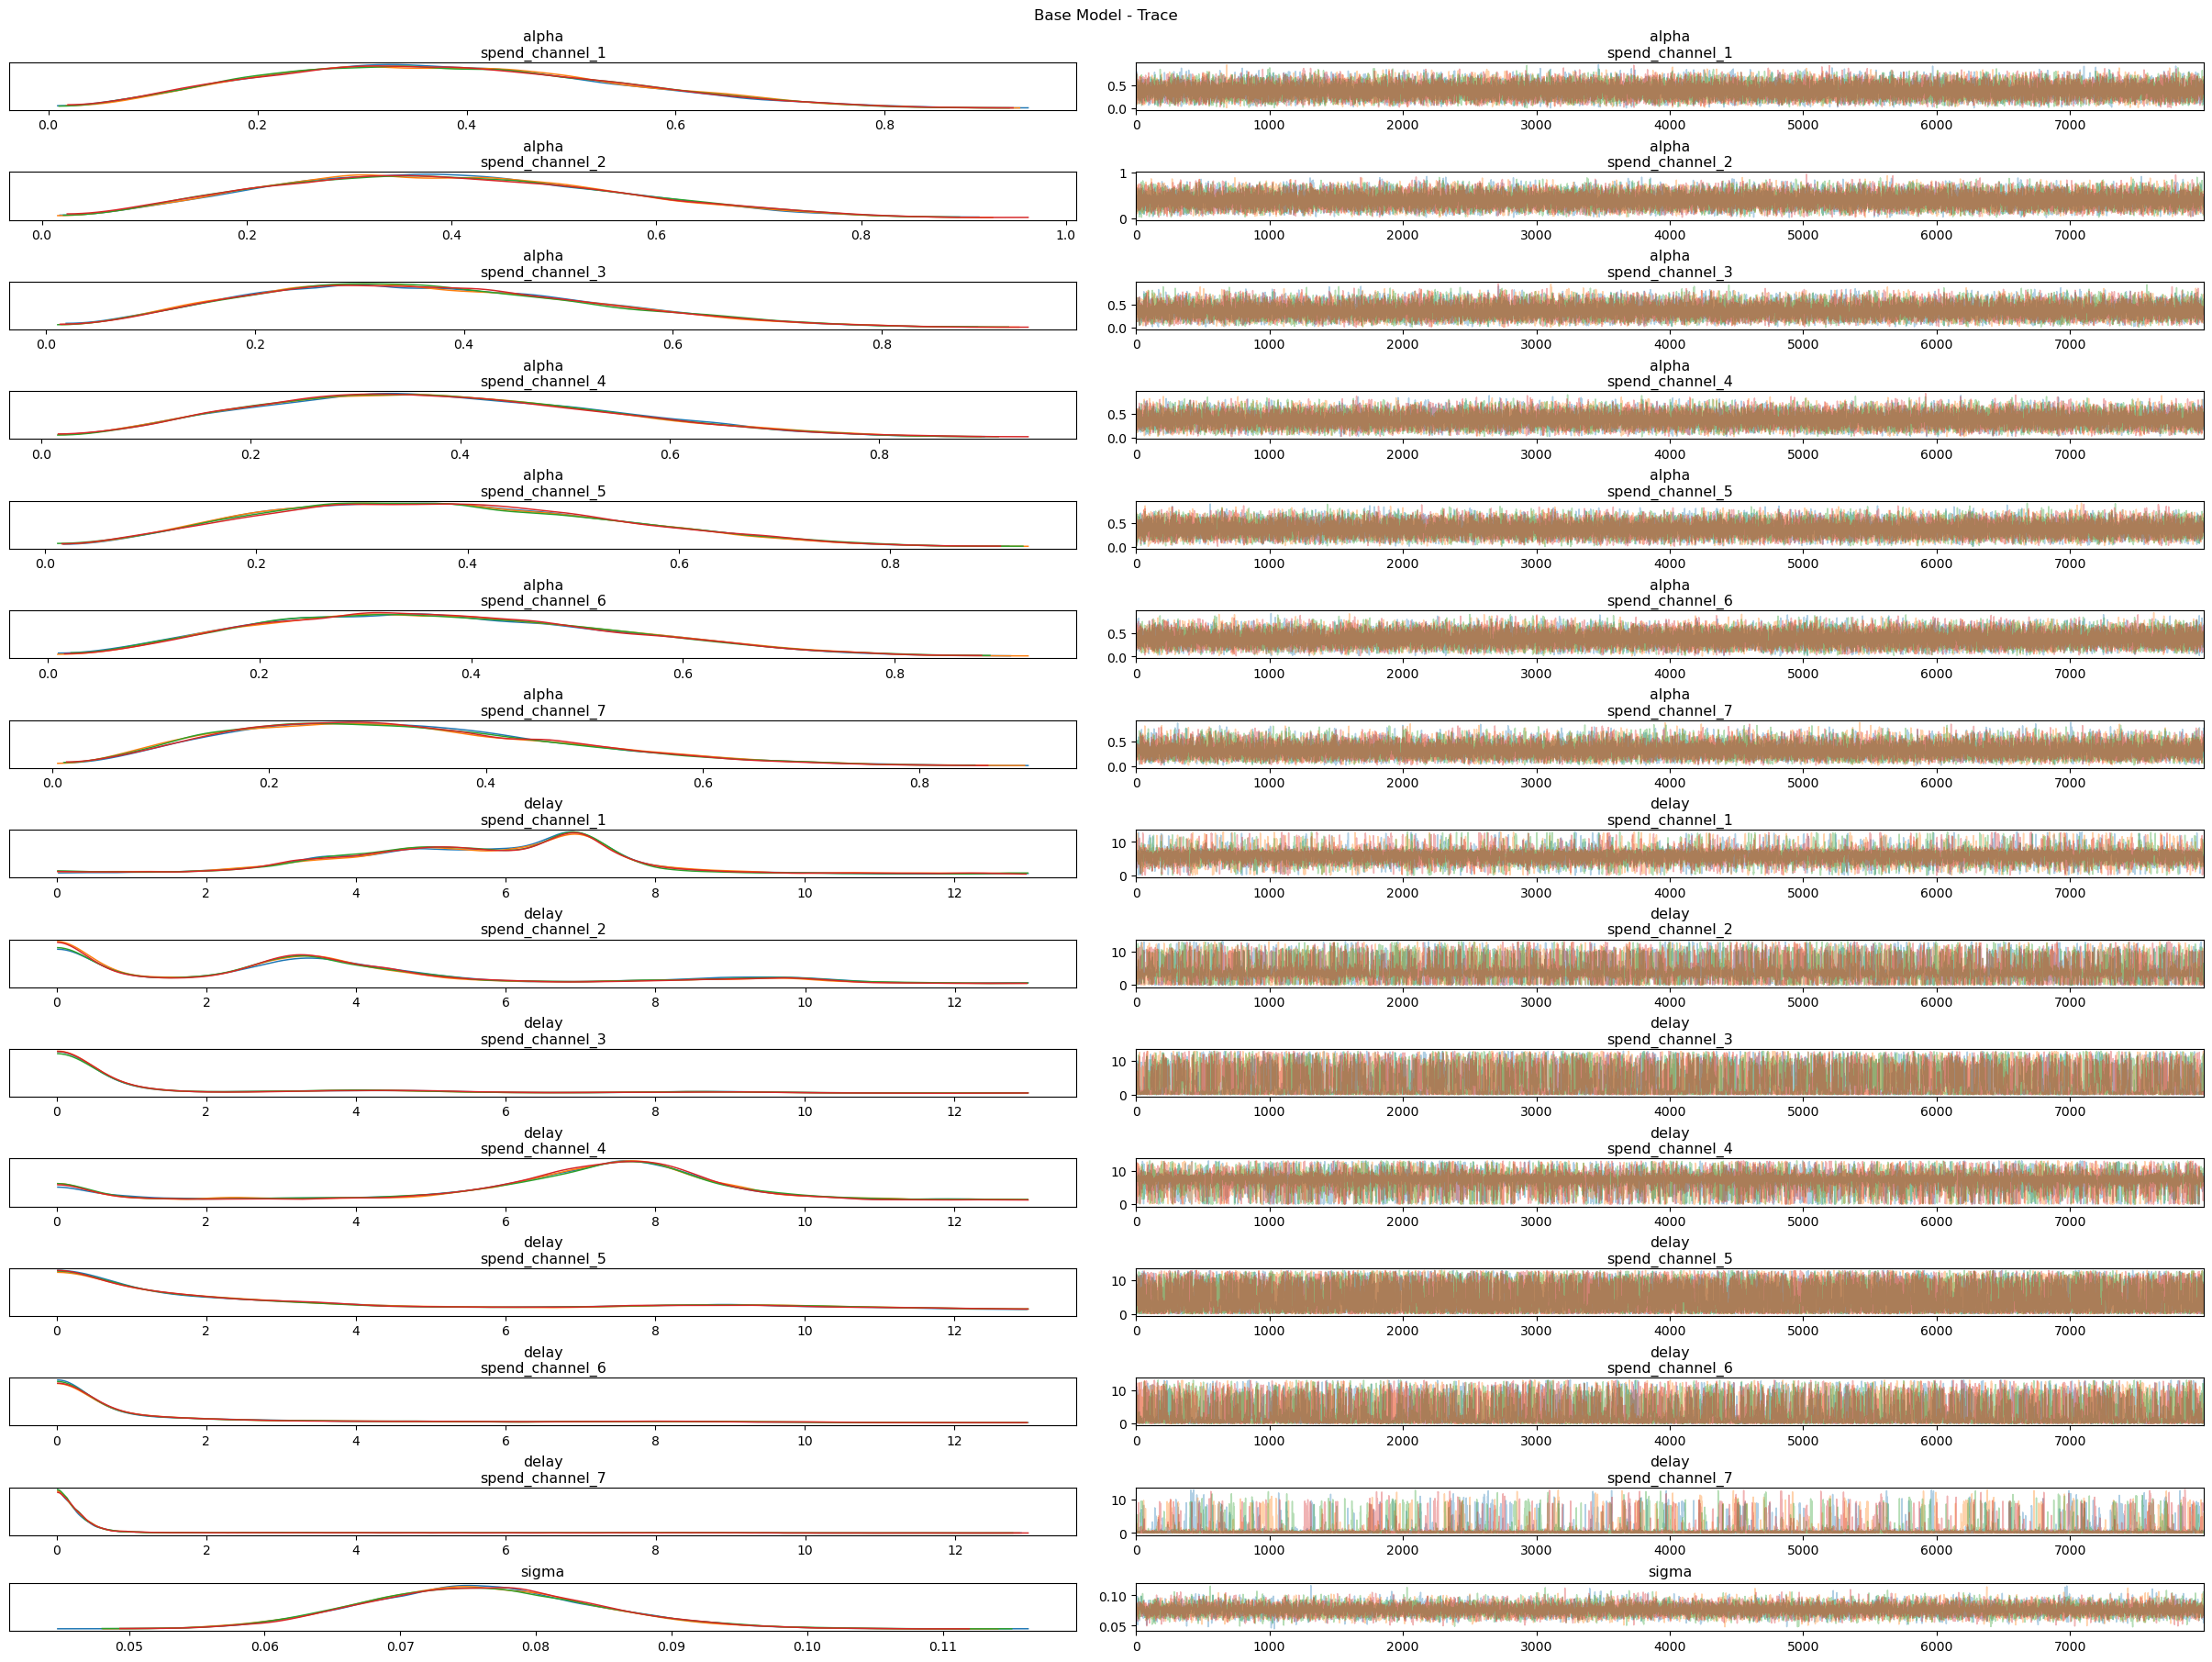

In [76]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','sigma'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 18),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()

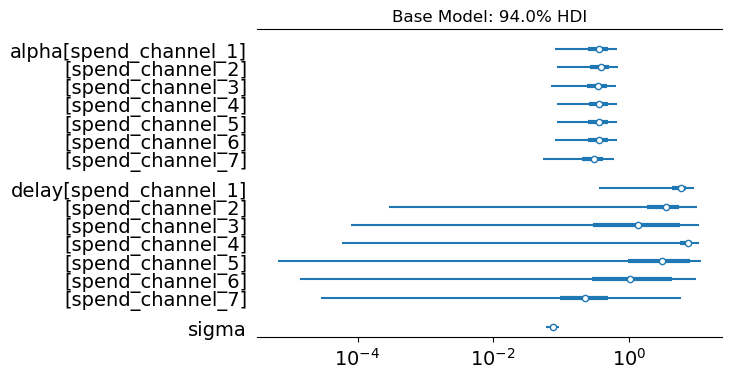

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
## posterior prediction

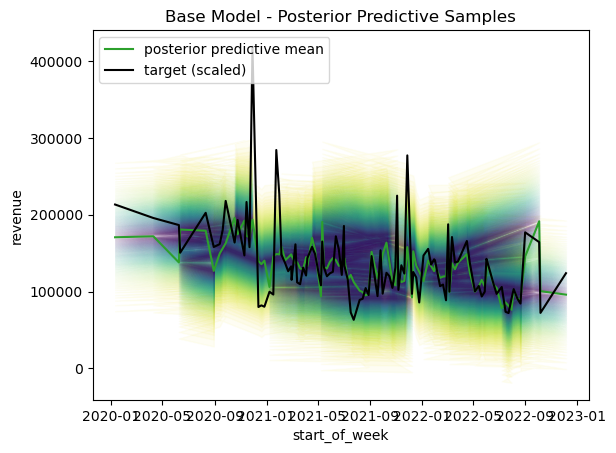

In [70]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


not the best 

In [81]:
model_hdi

<xarray.Dataset>
Dimensions:                (hdi: 2, control: 7, channel: 7, date: 104)
Coordinates:
  * control                (control) <U11 't' 'sin_order_1' ... 'cos_order_3'
  * channel                (channel) <U15 'spend_channel_1' ... 'spend_channe...
  * date                   (date) datetime64[ns] 2020-08-30 ... 2022-08-21
  * hdi                    (hdi) <U6 'lower' 'higher'
Data variables:
    intercept              (hdi) float64 0.1317 0.2903
    gamma_control          (control, hdi) float64 -0.3337 -0.0565 ... 0.03146
    beta_channel           (channel, hdi) float64 2.128e-05 0.2228 ... 0.4389
    alpha                  (channel, hdi) float64 0.08093 0.666 ... 0.5955
    delay                  (channel, hdi) float64 0.3649 9.189 ... 5.913
    sigma                  (hdi) float64 0.06029 0.09256
    nu                     (hdi) float64 4.487 16.16
    channel_adstock        (date, channel, hdi) float64 3.154e-238 ... 0.394
    channel_contributions  (date, channel, hdi) float64 4.886e-240 ... 0.1674
    control_contributions  (date, control, hdi) float64 -0.0 -0.0 ... 0.02695
    mu                     (date, hdi) float64 0.2372 0.3697 ... 0.1574 0.2686

In [95]:
model_trace.posterior['channel_contributions']

<xarray.DataArray 'channel_contributions' (chain: 4, draw: 8000, date: 104,
                                           channel: 7)>
array([[[[1.59936328e-007, 3.63871921e-008, 8.68766894e-022, ...,
          5.31496381e-002, 1.69003631e-006, 4.18507416e-002],
         [5.27423286e-005, 3.01226946e-006, 2.00097053e-017, ...,
          7.57205841e-002, 2.97344341e-005, 6.80629526e-002],
         [2.48894803e-003, 9.85308520e-005, 1.22328346e-013, ...,
          8.49146550e-002, 2.66186970e-004, 7.34179658e-002],
         ...,
         [9.18940439e-029, 5.53895212e-002, 1.19987996e-002, ...,
          2.26598274e-002, 0.00000000e+000, 9.00423045e-002],
         [1.31457469e-035, 4.48401921e-002, 1.47239785e-002, ...,
          2.00663431e-002, 0.00000000e+000, 9.45431718e-002],
         [0.00000000e+000, 5.69806896e-002, 1.83482551e-002, ...,
          1.78573475e-002, 0.00000000e+000, 9.79319778e-002]],

        [[4.08241298e-008, 6.59399605e-008, 9.88328799e-025, ...,
          1.96271230e-002, 4.55836369e-004, 6.15565456e-002],
         [7.35396118e-005, 1.12390111e-005, 4.67247178e-020, ...,
          3.18419275e-002, 1.62510755e-003, 1.00827965e-001],
         [6.27123935e-003, 4.64701381e-004, 6.03243329e-016, ...,
          3.54897858e-002, 2.71837587e-003, 1.09108479e-001],
...
         [1.79892873e-034, 4.42828855e-002, 5.55687251e-002, ...,
          1.93463138e-003, 0.00000000e+000, 4.00275645e-002],
         [1.72629748e-041, 7.37909344e-002, 4.35878765e-002, ...,
          2.01506879e-003, 0.00000000e+000, 4.95091933e-002],
         [0.00000000e+000, 4.40055315e-002, 3.82079874e-002, ...,
          2.04988796e-003, 0.00000000e+000, 5.57007298e-002]],

        [[8.13643802e-018, 1.65916183e-002, 3.86905826e-002, ...,
          7.61390909e-003, 1.23478571e-002, 3.57970335e-037],
         [8.08608822e-013, 1.64702460e-002, 4.00190009e-002, ...,
          1.27878830e-002, 2.55333926e-002, 2.49964774e-029],
         [8.46252355e-009, 1.09876979e-002, 3.12219029e-002, ...,
          1.49629889e-002, 2.45120825e-002, 1.73141139e-022],
         ...,
         [9.87623522e-019, 5.22906034e-002, 5.40820625e-002, ...,
          3.95455586e-003, 0.00000000e+000, 4.37155875e-002],
         [1.73204059e-024, 9.34852123e-002, 4.60286457e-002, ...,
          3.71785138e-003, 0.00000000e+000, 5.31987687e-002],
         [0.00000000e+000, 6.27863736e-002, 4.41954639e-002, ...,
          3.30943816e-003, 0.00000000e+000, 5.26393956e-002]]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 7993 7994 7995 7996 7997 7998 7999
  * channel  (channel) <U15 'spend_channel_1' ... 'spend_channel_7'
  * date     (date) datetime64[ns] 2020-08-30 2020-06-09 ... 2022-08-21